**Name: Mayuresh Rajesh Dindorkar**  
**Roll No.: CS23MTECH14007**  
**Deep Learning Assignment No. 2**  


In [31]:
# Importing the packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mplotimg
import warnings
warnings.filterwarnings("ignore")
import torch
from torch import nn
from torch.nn import Module
from collections import OrderedDict

In [32]:
# Code works correctly on both CPU as well as GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Device: cpu


---
**Utility functions:**

In [33]:
# Activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0, x)

def leaky_relu(x, alpha=0.01):
    return np.maximum(alpha*x, x)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

In [34]:
def plot_subplots(input_image, filter_kernel, output_sigmoid, output_relu, output_leaky_relu, output_tanh):
  # Create a subplot with larger size
  fig, axs = plt.subplots(3, 2, figsize=(8, 8))

  # Set aspect ratio for all subplots
  for ax in axs.flatten():
      ax.set_aspect('equal', adjustable='box')

  # Display the input image, filter kernel, and output activation maps
  axs[0, 0].imshow(input_image)
  axs[0, 0].set_title(f'Input Image, Shape:{input_image.shape}')

  axs[0, 1].imshow(filter_kernel)
  axs[0, 1].set_title(f'Filter Kernel, Shape:{filter_kernel.shape}')

  axs[1, 0].imshow(output_sigmoid)
  axs[1, 0].set_title(f'Sigmoid Activation, Shape:{output_sigmoid.shape}')

  axs[1, 1].imshow(output_relu)
  axs[1, 1].set_title(f'ReLU Activation, Shape:{output_relu.shape}')

  axs[2, 0].imshow(output_leaky_relu)
  axs[2, 0].set_title(f'Leaky Relu Activation, Shape:{output_leaky_relu.shape}')

  axs[2, 1].imshow(output_tanh)
  axs[2, 1].set_title(f'tanh Activation, Shape:{output_tanh.shape}')

  plt.tight_layout()
  plt.show()

In [35]:
def plot_graph(input_image, kernel_list, stacked_activation_maps):
  # Create a subplot with larger size
  fig, axs = plt.subplots(3, 2, figsize=(10, 10))

  # Set aspect ratio for all subplots
  for ax in axs.flatten():
      ax.set_aspect('equal', adjustable='box')

  # Display the input image, filter kernel, and output activation maps
  axs[0, 0].imshow(input_image)
  axs[0, 0].set_title(f'Input Image {input_image.shape}')

  axs[1, 0].imshow(kernel_list[0])
  axs[1, 0].set_title(f'Kernel 1 having shape: {kernel_list[0].shape}')

  axs[1, 1].imshow(stacked_activation_maps[:, :, 0])
  axs[1, 1].set_title(f'Activation Map 1 having shape: {stacked_activation_maps[:, :, 0].shape}')

  axs[2, 0].imshow(kernel_list[1])
  axs[2, 0].set_title(f'Kernel 2 having shape: {kernel_list[1].shape}')

  axs[2, 1].imshow(stacked_activation_maps[:, :,1])
  axs[2, 1].set_title(f'Activation Map 2 having shape: {stacked_activation_maps[:, :, 1].shape}')

  fig.delaxes(axs[0, 1])
  plt.tight_layout()
  plt.show()

In [36]:
def single_image_plot(img, title):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 1, 1)
    plt.title(title)
    plt.imshow(img)
    plt.show()

In [37]:
def plot_loss(epoch_loss_dict, title):
  plt.plot(list(epoch_loss_dict.keys()), list(epoch_loss_dict.values()), label='Training Loss', marker='o')
  plt.title(title)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [38]:
def read_image(img_path):
    input_image = mplotimg.imread(img_path)
    input_image.astype(np.float32) / 255.0
    return input_image

In [39]:
def get_embossing_filter():
    return np.array([
    [
      [-2, -1, 0],
      [-1, 1, 1],
      [0, 1, 2]
    ],
    [
      [-2, -1, 0],
      [-1, 1, 1],
      [0, 1, 2]
    ],
    [
      [-2, -1, 0],
      [-1, 1, 1],
      [0, 1, 2]
    ]
    ])

In [40]:
def calculate_output_activation_map_dimensions(Image_Height, Image_Width, Filter_Height, Filter_Width, P, S):
    New_Image_Width = ((Image_Width - Filter_Width + 2 * P) // S) + 1
    New_Image_Height = ((Image_Height - Filter_Height + 2 * P) // S) + 1
    return New_Image_Height, New_Image_Width

In [41]:
def extract_patch_from_image(input_image, i, j, filter_height, filter_width):
    return input_image[i:i + filter_height, j:j + filter_width, :]

---  
**Q1) Convolution Function:**

In [ ]:
def convolution_function(input_image, stride, filter, activation_function, padding = 0):
    # Extracting image dimensions
    input_height, input_width, input_channels = input_image.shape

    # Padding the image
    if padding == 0:
        input_image = input_image
    elif padding > 0:
        input_image = np.pad(input_image, ((padding, padding), (padding, padding), (0, 0)), mode='constant')
    elif padding < 0:
        raise ValueError("Padding cannot be negative number")

    # Extracting kernel dimensions
    filter_height, filter_width, filter_channels = filter.shape

    # Calculating output dimensions
    output_height, output_width = calculate_output_activation_map_dimensions(input_height, input_width, filter_height,
                                                              filter_width, P = padding, S = stride)

    # Initializing output activation map
    activation_map = np.zeros((output_height, output_width))

    for i in range(0, input_height - filter_height + 1, stride):
        for j in range(0, input_width - filter_width + 1, stride):
            patch = extract_patch_from_image(input_image, i, j, filter_height, filter_width)
            activation_map[i // stride, j // stride] = np.sum(patch[:, :, :filter_channels] * filter)

    # Applying activation function
    activation_map = activation_function(activation_map)
    return activation_map

Input Image Shape: (256, 256, 3)
Filter Shape: (3, 3, 3)


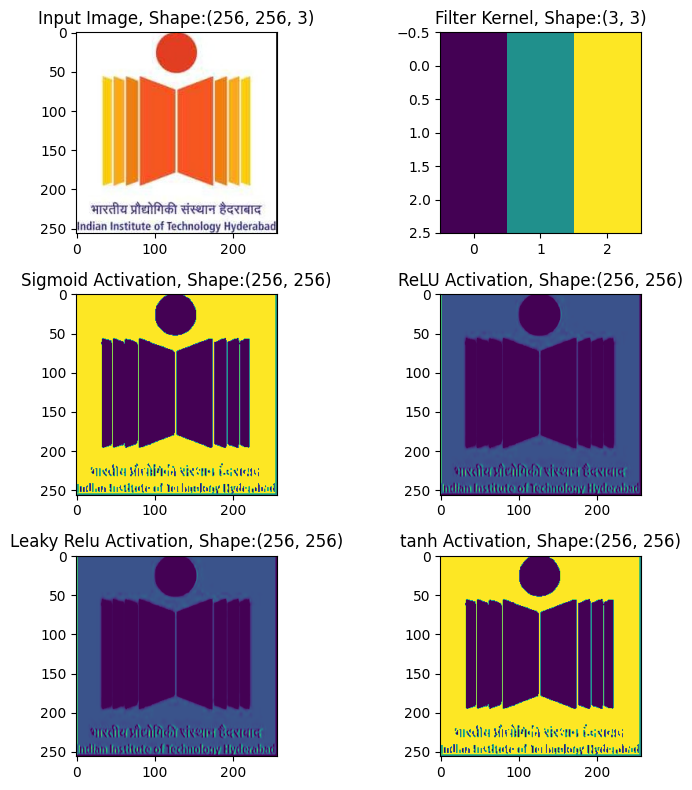

In [ ]:
# Reading the image
input_image = read_image('logo.jpeg')
print('Input Image Shape:', input_image.shape)

# Creating Embossing kernel
filter = get_embossing_filter()
print('Filter Shape:', filter.shape)

# Setting conv params
stride = 1
padding = 1

# Apply convolution with different activation functions
activation_map_sigmoid = convolution_function(input_image, stride, filter, sigmoid, padding)
activation_map_relu = convolution_function(input_image, stride, filter, relu, padding)
activation_map_leaky_relu = convolution_function(input_image, stride, filter, lambda x: leaky_relu(x), padding)
activation_map_tanh = convolution_function(input_image, stride, filter, tanh, padding)

# Plotting the graphs
plot_subplots(input_image, filter[:,:,0], activation_map_sigmoid, activation_map_relu,
              activation_map_leaky_relu, activation_map_tanh)

Dimensions of output activation map = (W - F + 2*P) / S + 1  
= (256 - 3 + 2*1) / 1 + 1  
= 256

---
**Q2) Pooling function:**

In [ ]:
def calculate_pooled_activation_map_dimensions(height, width, filter_height, filter_width, stride):
    new_height = (height - filter_height) // stride + 1
    new_width = (width - filter_width) // stride + 1
    return new_height, new_width

In [ ]:
def pooling_function(activation_map, pool_type='max', stride=2, filter_size=2):
    pooling_functions = {
        'max': np.max,
        'average': np.mean,
    }
    assert pool_type in ['max', 'average'], "Invalid pooling type. Use 'max' or 'average.'"
    activation_map = np.expand_dims(activation_map, axis=-1) if activation_map.ndim == 2 else activation_map

    # Extract activation map dimensions
    height, width, channels = activation_map.shape
    #Extract filter dimensions
    filter_height, filter_width = filter_size
    # Calculate new dimensions after pooling
    new_height, new_width = calculate_pooled_activation_map_dimensions(height, width, filter_height, filter_width, stride)

    # Initialize the pooled activation map
    pooled_act_map_shape = (new_height, new_width, channels)
    pooled_activation_map = np.zeros(pooled_act_map_shape)

    for c in range(channels):
        for i in range(new_height):
            for j in range(new_width):
                start_row, start_col = i * stride, j * stride
                end_row, end_col = start_row + filter_height, start_col + filter_width

                # Extract the region to pool across all channels
                region_to_pool = activation_map[start_row:end_row, start_col:end_col, :]

                # Normalize the region to pool
                region_to_pool = region_to_pool / 255.0  # Assuming values in the range [0, 255]

                # Apply pooling based on the pool_type
                pooled_activation_map[i, j, c] = pooling_functions[pool_type](region_to_pool)

    return pooled_activation_map

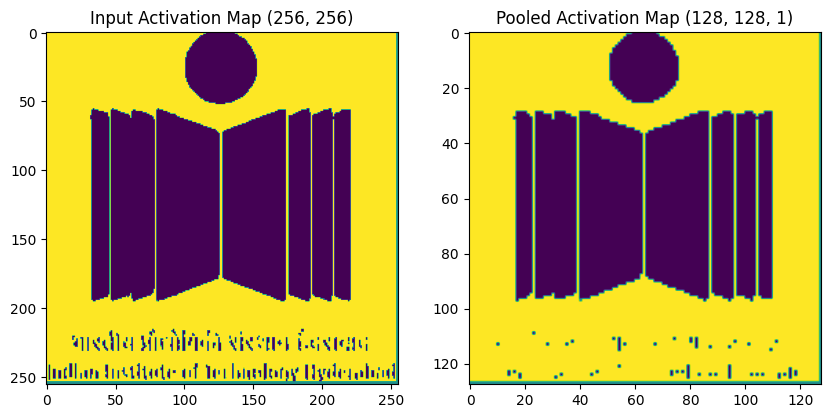

In [ ]:
pooled_activation_map = pooling_function(activation_map_sigmoid, pool_type='max', stride=2, filter_size=(2,2))

# Plot original and pooled activation maps
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title(f"Input Activation Map {activation_map_sigmoid.shape}")
plt.imshow(activation_map_sigmoid)

plt.subplot(1, 2, 2)
plt.title(f"Pooled Activation Map {pooled_activation_map.shape}")
plt.imshow(pooled_activation_map)

plt.show()

Dimensions of pooled activation map = (W - F) / S + 1  
= (256 - 2) / 2 + 1  
= 128

---
**Q3) Convolution Layer function:**

In [ ]:
def convolution_layer(input_image, number_of_filters, filter_dimensions, stride, padding, activation_function):
    # Getting input image dimensions
    input_height, input_width, input_channels = input_image.shape
    filter_height, filter_width = filter_dimensions

    activation_maps_list = []
    filters_list = []

    # Applying the filters and obtaining the corresponding activation map for each filter
    for i in range(0, number_of_filters, 1):
        filter = np.random.randn(filter_height, filter_width, input_channels)
        activation_maps_list.append(convolution_function(input_image=input_image, stride=stride, filter=filter,
                                                        activation_function=activation_function, padding=padding))
        filters_list.append(filter)

    stacked_activation_maps = np.stack(activation_maps_list, axis=-1)
    return stacked_activation_maps, filters_list

Shape of Input Image: (256, 256, 3)


Shape of Convolution Layer Output: (256, 256, 10)


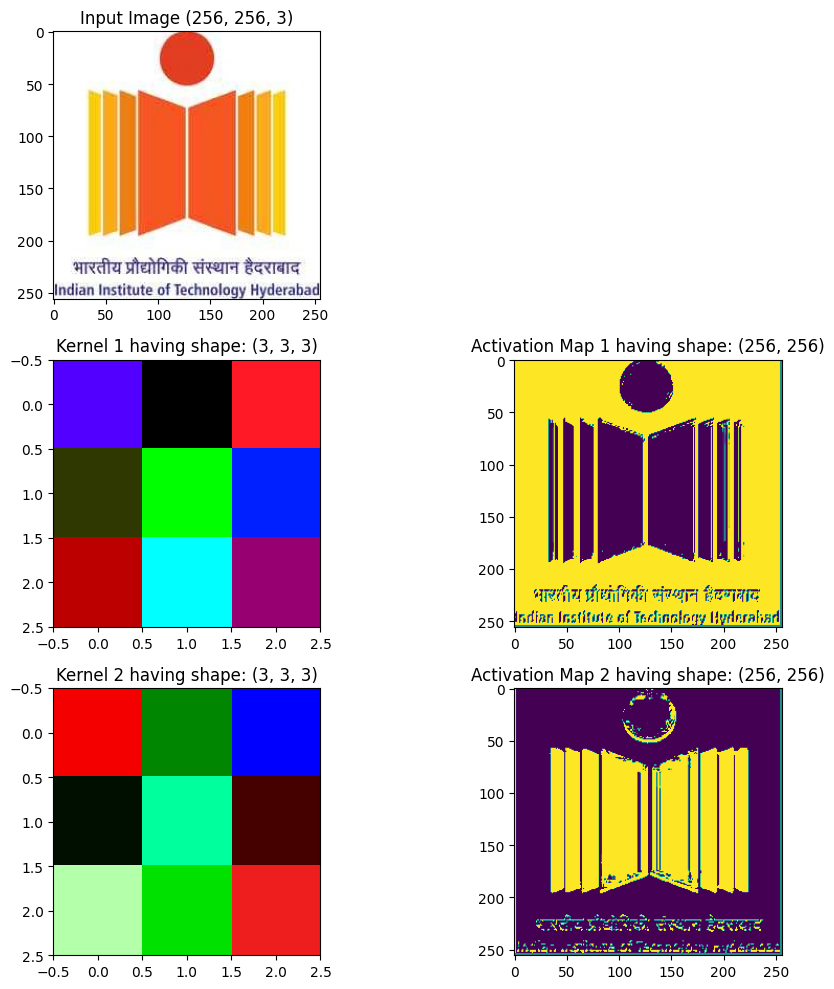

In [ ]:
# Reading the image
input_image = read_image('logo.jpeg')
print('Shape of Input Image:', input_image.shape)

# Set convolution parameters
stride = 1
padding = 1
filter_dimensions = (3,3)
number_of_filters = 10

# Apply convolution with different activation functions
stacked_activation_maps, kernels_list = convolution_layer(input_image, number_of_filters, filter_dimensions, stride, padding, sigmoid)

print('Shape of Convolution Layer Output:', stacked_activation_maps.shape)
plot_graph(input_image, kernels_list, stacked_activation_maps)

---
**Q4) Pooling layer function:**

In [ ]:
def pooling_layer(activation_map, pool_type='max', stride=2, filter_size=(2,2)):
    assert pool_type in ['max', 'average', 'global_average'], "Invalid pooling type. Use 'max', 'average', or 'global_average'."

    if pool_type == 'global_average':
        if len(activation_map.shape) == 2:
            activation_map = np.expand_dims(activation_map, axis=-1)
        height, width, channels = activation_map.shape
        # Global average pooling
        return np.mean(activation_map, axis=(0, 1), keepdims=True).reshape(-1)
    return pooling_function(activation_map, pool_type, stride, filter_size)

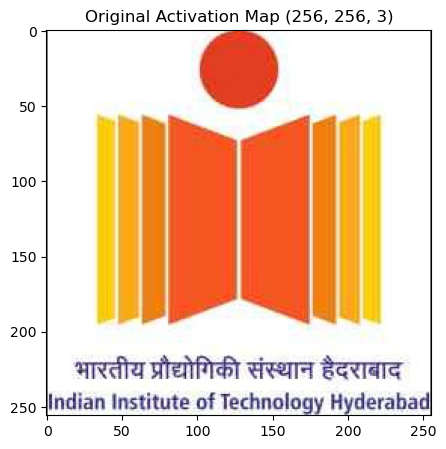

Shape: (3,)
global_average Pooling output: [239.57614136 194.65971375 162.18818665]


In [ ]:
# Reading the image
input_image = read_image('logo.jpeg')
# Plot original and pooled activation maps
single_image_plot(input_image, f"Original Activation Map {input_image.shape}")

pool_type='global_average'
pooled_activation_map = pooling_layer(activation_map=input_image, pool_type=pool_type, stride=2, filter_size=(2,2))

if pool_type == 'global_average':
    print('Shape:', pooled_activation_map.shape)
    print(pool_type, 'Pooling output:', pooled_activation_map)
else:
    print(pool_type, 'Pooling output:')
    single_image_plot(pooled_activation_map, f"Pooled Activation Map {pooled_activation_map.shape}")

Global Average Pooling layer gives a single average value for each channel.   
Hence, length of output array == Number of channels in input volume

---  
**Q5) Multilayer Perceptron (MLP) function:**  
**Obtaning a activation map, then will passs it as an input to Feedforward neural network:**

In [ ]:
input_image = read_image('logo.jpeg')
print('Shape of Input Image:', input_image.shape)

# Passing the input image to Conv2D layer
stacked_activation_maps, kernels_list = convolution_layer(input_image, number_of_filters = 10, filter_dimensions = (3,3),
                                                          stride = 1, padding = 0, activation_function=relu)
print('Shape of Output from first Conv2D layer:', stacked_activation_maps.shape)

# Passing the conv2D layer output to GAP pooling layer
gap_output = pooling_layer(stacked_activation_maps, pool_type='global_average', stride=2)
print('Shape of Output from GAP layer:', gap_output.shape)
print('Printing Output from GAP layer:', gap_output)

Shape of Input Image: (256, 256, 3)
Shape of Output from first Conv2D layer: (254, 254, 10)
Shape of Output from GAP layer: (10,)
Printing Output from GAP layer: [2.49469144e-01 1.24150254e-03 2.97075039e+02 1.22371060e+02
 9.22294025e+02 3.78716114e+02 1.51716246e+00 1.27192796e+02
 2.45824788e-01 2.96753219e+02]


**Creating MLP:**

In [ ]:
class MultiLayerPerceptron:
    def __init__(self, input_layer_size, no_of_hidden_layers, hidden_layer_sizes, act_function, output_size):
        self.input_layer_size = input_layer_size
        self.hidden_layer_sizes = hidden_layer_sizes
        self.act_function = act_function
        self.output_size = output_size
        self.no_of_hidden_layers = no_of_hidden_layers

        # Initialize weights and biases for hidden layers
        self.weights = list()
        layer_input_size = input_layer_size
        self.biases = list()
        for layer_size in hidden_layer_sizes:
            self.weights.append(np.random.randn(layer_input_size, layer_size))
            self.biases.append(np.zeros(layer_size))
            layer_input_size = layer_size

        # Initialize weights and biases for output layer
        self.weights.append(np.random.randn(layer_input_size, output_size))
        self.biases.append(np.zeros(output_size))

    def forward_prop(self, input_vector, use_softmax_in_output_layer=True):
        # Forward pass through hidden layers, for loop selects all elements in the list except the last one.
        # last value will be used for output layer
        output = input_vector
        for w, b in zip(self.weights[:-1], self.biases[:-1]):
            Z = output @ w + b
            output = self.act_function(Z)
        # Forward pass through output layer
        output = output @ self.weights[-1] + self.biases[-1]

        # Apply softmax to the output layer output, if specified
        if True == use_softmax_in_output_layer:
            return softmax(output)
        else:
            return output

**Obtained the MLP output for vector:**

In [ ]:
# creating MultilayerPerceptron class object
mlp = MultiLayerPerceptron(input_layer_size=gap_output.shape[0], no_of_hidden_layers=2, hidden_layer_sizes=[4,3], act_function=relu, output_size=4)

# Forward pass
output_without_softmax = mlp.forward_prop(gap_output, use_softmax_in_output_layer=False)
output_with_softmax = mlp.forward_prop(gap_output, use_softmax_in_output_layer=True)

print("Output without softmax:", output_without_softmax)
print("Output with softmax:", output_with_softmax)

Output without softmax: [-240.57821008  255.87112938   -5.18770521  -13.93237123]
Output with softmax: [2.48194028e-216 1.00000000e+000 4.20328350e-114 6.69620108e-118]


**Q6) Putting-it all together:**  
**Creeating the CNN:**

In [ ]:
def CNN(input_image):
  # Conv layer with 16 kernels of 5 × 5 dimension & ReLU activation.
  act_maps_1, kernels_list1 = convolution_layer(input_image, number_of_filters = 16, filter_dimensions = (5,5),
                                                          stride = 1, padding = 0, activation_function=relu)
  print('Shape of Output (Activation Maps) from 1st Conv2D layer:', act_maps_1.shape)
  single_image_plot(act_maps_1[:, :, 0], f"Activation Map 1, Shape:{act_maps_1[:, :, 0].shape}")

  # Max pool layer with 2 × 2 kernel and stride = 2
  pool1 = pooling_layer(act_maps_1, pool_type='max', stride=2, filter_size=(2,2))
  print('Shape of Output from pool1 layer:', pool1.shape)
  single_image_plot(pool1[:, :, 0], f"Pool1, Shape:{pool1[:, :, 0].shape}")

  # Conv layer with 32 kernels of spatial size 3 × 3 and sigmoid activation.
  act_maps_2, kernels_list_2 = convolution_layer(pool1, number_of_filters = 32, filter_dimensions = (3,3),
                                                          stride = 1, padding = 0, activation_function=sigmoid)
  print('Shape of Output (Activation Maps) from 2nd Con2D layer:', act_maps_2.shape)
  single_image_plot(act_maps_2[:, :, 0], f"Activation Map 1, Shape:{act_maps_2[:, :, 0].shape}")

  # Max pool layer with 2 × 2 kernel and stride = 2
  pool2 = pooling_layer(act_maps_2, pool_type='max', stride=2, filter_size=(2,2))
  print('Shape of Output from pool2 layer:', pool2.shape)
  single_image_plot(pool2[:, :, 0], f"Pool2, Shape:{pool2[:, :, 0].shape}")

  # GAP layer
  gap_layer_output = pooling_layer(pool2, pool_type='global_average')
  print('Shape of Output from GAP layer:', gap_layer_output.shape)

  # Creating MultilayerPerceptron class object
  # An MLP with one hidden layer (size same as input) that accepts as input the previous layer’s
  # output and maps it to 1000 output nodes. Use ReLU activation for the MLP (softmax in the o/p layer)
  # gap_layer_output.shape[0] == 32
  mlp1 = MultiLayerPerceptron(input_layer_size=gap_layer_output.shape[0], no_of_hidden_layers=1,
                              hidden_layer_sizes=[gap_layer_output.shape[0]], act_function=relu, output_size=1000)
  # Forward pass
  pred = mlp1.forward_prop(gap_layer_output, use_softmax_in_output_layer=True)
  return pred

Downloaded the ILSVRC dataset Validation set images from: [kaggle](https://www.kaggle.com/datasets/hmendonca/imagenet-1k-tfrecords-ilsvrc2012-part-0)

Shape of Input Image: (224, 224, 3)


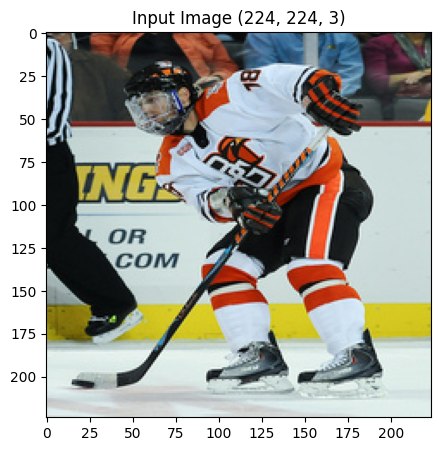

******** CNN *******
Shape of Output (Activation Maps) from 1st Conv2D layer: (220, 220, 16)


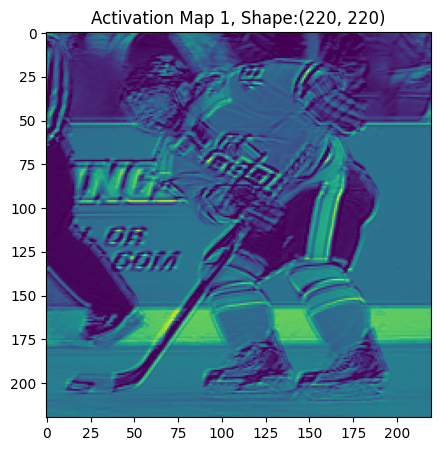

Shape of Output from pool1 layer: (110, 110, 16)


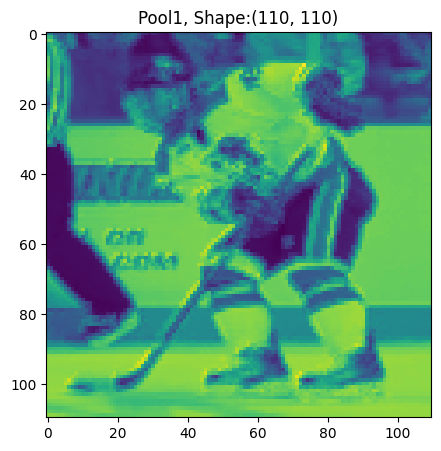

Shape of Output (Activation Maps) from 2nd Con2D layer: (108, 108, 32)


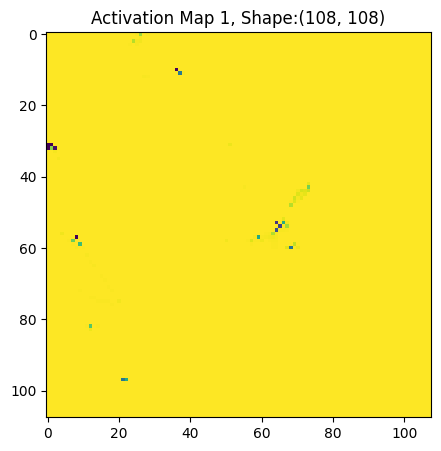

Shape of Output from pool2 layer: (54, 54, 32)


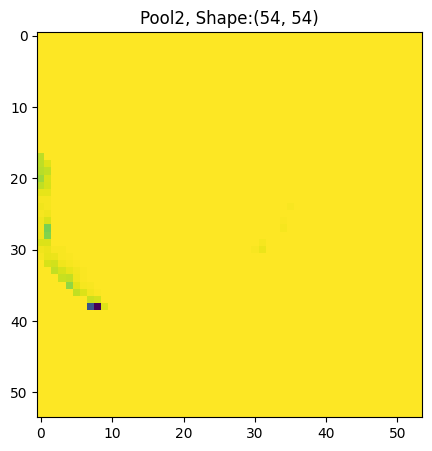

Shape of Output from GAP layer: (32,)
Shape of MLP Output with softmax: (1000,)


In [ ]:
input_image = read_image('ILSVRC2012_val_00049790.jpeg')
print('Shape of Input Image:', input_image.shape)
single_image_plot(input_image, f"Input Image {input_image.shape}")

print('='*60)
print('******** CNN *******')
pred = CNN(input_image)
print("Shape of MLP Output with softmax:", pred.shape)

---  
**Sequence Models:**  
**Q7) Addition problem:**  
**1. Created the dataset:**

In [42]:
def generate_data(num_samples):
    X = []
    Y = []
    for _ in range(num_samples):
        seq_length = torch.randint(3, 10, (1,)).item()
        sequence = torch.rand((seq_length, 2), dtype=torch.float64)
        mark_indices = torch.randperm(seq_length)[:2]
        sequence[:, 1] = 0  # Reset second dimension
        sequence[mark_indices, 1] = 1  # Mark two elements with 1
        X.append(sequence)
        Y_value = torch.sum(sequence[mark_indices, 0])
        Y.append(Y_value.view(1))  # Convert Y_value to a tensor
    return X, Y

# Generate Data
X, Y = generate_data(5000)
print('X.shape:', len(X))
print('Y.shape:', len(Y))

X.shape: 5000
Y.shape: 5000


In [43]:
X[0]

tensor([[0.0558, 0.0000],
        [0.9690, 1.0000],
        [0.3345, 0.0000],
        [0.8785, 0.0000],
        [0.9974, 1.0000],
        [0.1145, 0.0000],
        [0.8807, 0.0000]], dtype=torch.float64)

In [44]:
Y[0]

tensor([1.9664], dtype=torch.float64)

In [45]:
X[1]

tensor([[0.4657, 0.0000],
        [0.8983, 0.0000],
        [0.2147, 0.0000],
        [0.5989, 1.0000],
        [0.3570, 1.0000],
        [0.0592, 0.0000]], dtype=torch.float64)

In [46]:
Y[1]

tensor([0.9559], dtype=torch.float64)

In [47]:
X_train = X
Y_train = Y

---  
**2. Implementing Elman RNN:**  
W_xh = Input to hidden weight  
W_hh = Hidden to hidden weight  
W_hy = Hidden to output weight

b_h = bias of hidden state  
b_y = bias for output  

Reference: Classroom PPT  

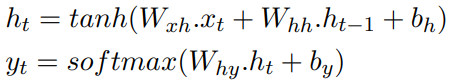

In [48]:
class RecurrentNeuralNetwork(nn.Module):
    def __init__(self, size_of_input, hidden_size, size_of_output):
        super(RecurrentNeuralNetwork, self).__init__()
        self.size_of_input = size_of_input
        self.hidden_size = hidden_size
        self.size_of_output = size_of_output
        self.create_weights_and_biases()
        self.init_weights()
        self.double()

    def create_weights_and_biases(self):
        self.W_xh = nn.Parameter(torch.randn(hidden_size, size_of_input))
        self.W_hh = nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.W_hy = nn.Parameter(torch.randn(size_of_output, hidden_size))
        self.b_h = nn.Parameter(torch.zeros(hidden_size))
        self.b_y = nn.Parameter(torch.zeros(size_of_output))

    def init_weights(self):
        # Initializing weights with Xavier initialization
        nn.init.xavier_uniform_(self.W_xh)
        nn.init.xavier_uniform_(self.W_hh)
        nn.init.xavier_uniform_(self.W_hy)

    def forward(self, x_t, h_t_minus_1):
        h_t = torch.tanh(torch.matmul(self.W_xh, x_t) + torch.matmul(self.W_hh, h_t_minus_1) + self.b_h)
        y_t = torch.matmul(self.W_hy, h_t) + self.b_y
        return y_t, h_t

In [49]:
def fit_RNN(opt, loss_function, rnn_model, X_train, Y_train, epochs = 8):
  ep = 0
  loss_history_per_epoch_dict = OrderedDict()
  rnn_model.to(device)
  while ep < epochs:
    i = 0
    total_loss_of_current_epoch = 0.0

    # Iterating over entire Training set
    no_of_samples = len(X_train)
    while i < no_of_samples:
      opt.zero_grad()

      X_sample = X_train[i]
      Y_true = Y_train[i]
      X_sample, Y_true = X_sample.to(device), Y_true.to(device)
      Y_t = 0

      h_t = torch.zeros(rnn_model.hidden_size, requires_grad=False, dtype=torch.float64)
      h_t = h_t.to(device)

      # Iterating over entire sequence of each sample
      no_of_sequences_in_sample = X_sample.shape[0]
      for t in range(0, no_of_sequences_in_sample, 1):
          Y_t, h_t = rnn_model(X_sample[t,:], h_t)

      loss = loss_function(Y_true, Y_t)
      loss.backward()
      opt.step()

      total_loss_of_current_epoch = total_loss_of_current_epoch + loss.detach().item()
      i = i + 1
    ep = ep + 1

    average_loss_of_current_epoch = total_loss_of_current_epoch / no_of_samples
    loss_history_per_epoch_dict[ep] = average_loss_of_current_epoch
    print('Epoch:', ep, 'has Loss:', loss_history_per_epoch_dict[ep])
  return loss_history_per_epoch_dict

In [50]:
# Initializing the hyperparameters, will be same for all (RNN, LSTM, GRU)
lr = 0.001
epochs = 22
size_of_input= 2
hidden_size= 8
size_of_output = 1

Printing RNN: RecurrentNeuralNetwork()
Epoch: 1 has Loss: 0.21854563064095245
Epoch: 2 has Loss: 0.06524911535605016
Epoch: 3 has Loss: 0.02945620274890415
Epoch: 4 has Loss: 0.019419471512813997
Epoch: 5 has Loss: 0.011958902830856568
Epoch: 6 has Loss: 0.007982858804637637
Epoch: 7 has Loss: 0.006200331188201459
Epoch: 8 has Loss: 0.005251373714005783
Epoch: 9 has Loss: 0.004656384023734449
Epoch: 10 has Loss: 0.004223342142981521
Epoch: 11 has Loss: 0.003875442524000865
Epoch: 12 has Loss: 0.0035798607785848843
Epoch: 13 has Loss: 0.0033205099152721885
Epoch: 14 has Loss: 0.0030884717522551863
Epoch: 15 has Loss: 0.0028785905002367508
Epoch: 16 has Loss: 0.0026881647656191395
Epoch: 17 has Loss: 0.002516194022127489
Epoch: 18 has Loss: 0.002362501434483371
Epoch: 19 has Loss: 0.0022266734610476204
Epoch: 20 has Loss: 0.0021073681910928903
Epoch: 21 has Loss: 0.0020024556004160305
Epoch: 22 has Loss: 0.0019096444226661252


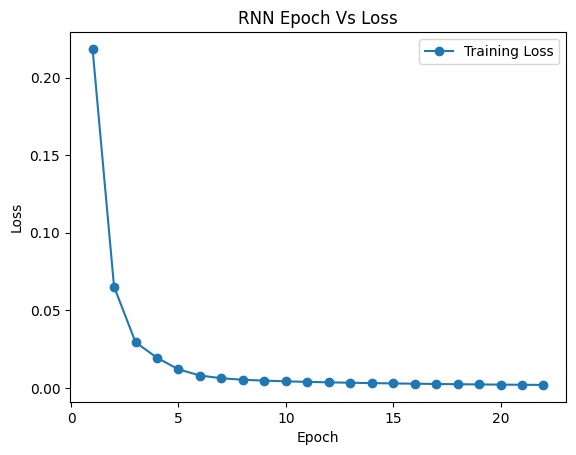

In [51]:
# Creating RecurrentNeuralNetwork model
torch.manual_seed(1000)
rnn = RecurrentNeuralNetwork(size_of_input=size_of_input, hidden_size=hidden_size, size_of_output = size_of_output)
rnn = rnn.to(device)
print("Printing RNN:", rnn)

# Training the RNN model
opt = torch.optim.NAdam(rnn.parameters(), lr = lr)
loss_function = nn.MSELoss()
epoch_loss_dict_rnn = fit_RNN(opt, loss_function, rnn, X_train, Y_train, epochs = epochs)
plot_loss(epoch_loss_dict_rnn, 'RNN Epoch Vs Loss')

---  
**3. Implementing LSTM:**  
Input x to Input Gate Weights (W_xi), Hidden state h to Input Gate Weights (W_hi), and Input Gate Bias (b_i)  
Input x to Forget Gate Weights (W_xf), Hidden state h to Forget Gate Weights (W_hf), and Forget Bias (b_f)  
Input x to Candidate Cell State C_tilda Weights (W_x_c_tilda), Hidden state to Candidate Cell State Weights (W_h_c_tilda), and Candidate Cell State Bias (b_c_tilda)  
Input x to Output Gate Weights (W_xo), Hidden state to Output Gate Weights (W_ho), and Output Gate Bias (b_o)  

Reference: Classroom PPT   
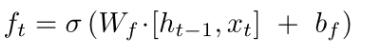  
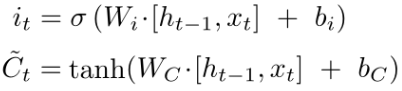  
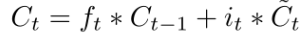  
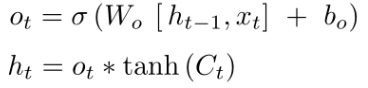  

In [61]:
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.create_weights_and_biases()
        self.double()

    def create_weights_and_biases(self):
        self.W_xi = nn.Parameter(torch.randn(self.hidden_size, self.input_size))
        self.W_hi = nn.Parameter(torch.randn(self.hidden_size, self.hidden_size))
        self.b_i = nn.Parameter(torch.zeros(1, self.hidden_size))

        self.W_xf = nn.Parameter(torch.randn(self.hidden_size, self.input_size))
        self.W_hf = nn.Parameter(torch.randn(self.hidden_size, self.hidden_size))
        self.b_f = nn.Parameter(torch.zeros(1, self.hidden_size))

        self.W_x_c_tilda = nn.Parameter(torch.randn(self.hidden_size, self.input_size))
        self.W_h_c_tilda = nn.Parameter(torch.randn(self.hidden_size, self.hidden_size))
        self.b_c_tilda = nn.Parameter(torch.zeros(1, self.hidden_size))

        self.W_xo = nn.Parameter(torch.randn(self.hidden_size, self.input_size))
        self.W_ho = nn.Parameter(torch.randn(self.hidden_size, self.hidden_size))
        self.b_o = nn.Parameter(torch.zeros(1, self.hidden_size))

        self.Wout = nn.Parameter(torch.randn(self.output_size, self.hidden_size))
        self.bout = nn.Parameter(torch.zeros(1, self.output_size))

    def forward(self, x, hc):
        h_t, c_t = hc

        # Transpose x if it's a row vector
        x = x.unsqueeze(0) if len(x.size()) == 1 else x

        i_t = torch.sigmoid(torch.matmul(self.W_xi, x.t()) + torch.matmul(self.W_hi, h_t.t()) + self.b_i)
        f_t = torch.sigmoid(torch.matmul(self.W_xf, x.t()) + torch.matmul(self.W_hf, h_t.t()) + self.b_f)
        c_tilda_t = torch.tanh(torch.matmul(self.W_x_c_tilda, x.t()) + torch.matmul(self.W_h_c_tilda, h_t.t()) + self.b_c_tilda)
        o_t = torch.sigmoid(torch.matmul(self.W_xo, x.t()) + torch.matmul(self.W_ho, h_t.t()) + self.b_o)

        # Update the cell state
        selective_forget = f_t * c_t
        selective_read = i_t * c_tilda_t
        c_t = selective_forget + selective_read
        h_t = o_t * torch.tanh(c_t)

        output = torch.matmul(self.Wout, h_t) + self.bout
        return output, (h_t, c_t)

In [62]:
def fit_LSTM(opt, loss_function, lstm_model, X_train, Y_train, epochs=8):
    ep = 0
    loss_history_per_epoch_dict = OrderedDict()
    lstm_model.to(device)
    while ep < epochs:
        i = 0
        total_loss_of_current_epoch = 0.0

        # Iterating over the entire training set
        no_of_samples = len(X_train)
        while i < no_of_samples:
            opt.zero_grad()

            X_sample = X_train[i]
            X_sample = X_sample.to(device)
            Y_true = Y_train[i]
            Y_true = Y_true.to(device)

            Y_t = 0
            h_t = torch.zeros(1, lstm_model.hidden_size, requires_grad=False, dtype=torch.float64)
            h_t = h_t.to(device)
            c_t = torch.zeros(1, lstm_model.hidden_size, requires_grad=False, dtype=torch.float64)
            c_t = c_t.to(device)

            # Iterating over the entire sequence of each sample
            no_of_sequences_in_sample = X_sample.shape[0]
            for t in range(0, no_of_sequences_in_sample, 1):
                Y_t, (h_t, c_t) = lstm_model(X_sample[t, :], (h_t, c_t))

            loss = loss_function(Y_t, Y_true)
            loss.backward()
            opt.step()

            total_loss_of_current_epoch = total_loss_of_current_epoch + loss.detach().item()
            i = i + 1
        ep = ep + 1

        average_loss_of_current_epoch = total_loss_of_current_epoch / no_of_samples
        loss_history_per_epoch_dict[ep] = average_loss_of_current_epoch
        print('Epoch:', ep, 'has Loss:', loss_history_per_epoch_dict[ep])
    return loss_history_per_epoch_dict

Printing LSTM: CustomLSTM()
Epoch: 1 has Loss: 0.13664623217024857
Epoch: 2 has Loss: 0.01927403844781071
Epoch: 3 has Loss: 0.008469620037168354
Epoch: 4 has Loss: 0.0050499024149441634
Epoch: 5 has Loss: 0.0034677941060992042
Epoch: 6 has Loss: 0.0025365446226974205
Epoch: 7 has Loss: 0.001885310755936272
Epoch: 8 has Loss: 0.0014099816827608982
Epoch: 9 has Loss: 0.0010860160842046716
Epoch: 10 has Loss: 0.000875332543889275
Epoch: 11 has Loss: 0.0007315453976930971
Epoch: 12 has Loss: 0.0006255993349794002
Epoch: 13 has Loss: 0.0005429800422211114
Epoch: 14 has Loss: 0.00047613675026604633
Epoch: 15 has Loss: 0.00042069310886760984
Epoch: 16 has Loss: 0.0003738668734887203
Epoch: 17 has Loss: 0.0003337682036230927
Epoch: 18 has Loss: 0.0002990522826885115
Epoch: 19 has Loss: 0.00026873253994004617
Epoch: 20 has Loss: 0.0002420710303144539
Epoch: 21 has Loss: 0.00021850506507284075
Epoch: 22 has Loss: 0.00019759340016922559


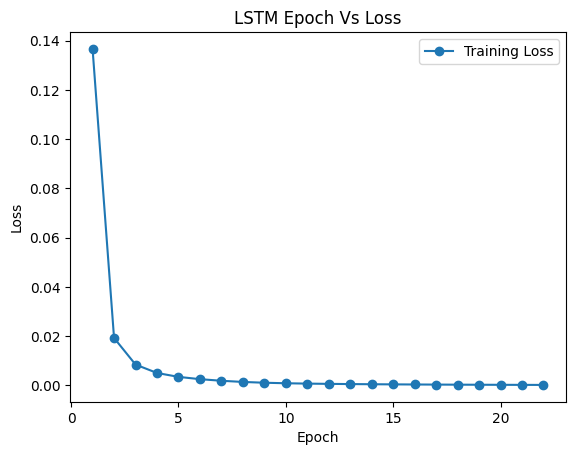

In [63]:
# Create LSTM model
torch.manual_seed(1000)
lstm_model = CustomLSTM(input_size = size_of_input, hidden_size = hidden_size, output_size = size_of_output)
print('Printing LSTM:', lstm_model)

# Train LSTM model
optimizer = torch.optim.NAdam(lstm_model.parameters(), lr = lr)
loss_function_LSTM = nn.MSELoss()
epoch_loss_dict_LSTM = fit_LSTM(optimizer, loss_function_LSTM, lstm_model, X_train, Y_train, epochs = epochs)
plot_loss(epoch_loss_dict_LSTM, 'LSTM Epoch Vs Loss')

---  
**4. Implementing GRU:**  
W_xr: Input x to reset gate weights  
W_xz: Input x to update gate weights  
W_xh: Input x to candidate hidden state (h_hat) weights  

W_xz: Input x to update gate weights  
W_hz: Hidden state h to update gate weights   
W_hh: Hidden state h candidate hidden state (h_hat) weights   

b_r: Bias for the reset gate  
b_z: Bias for the update gate  
b_h: Bias for the candidate hidden state  

Reference: [Wikipedia](https://en.wikipedia.org/wiki/Gated_recurrent_unit)  
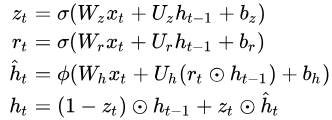

In [64]:
class CustomGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomGRU, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.create_weights_and_biases()
        self.double()

    def create_weights_and_biases(self):
        self.W_xr = torch.nn.Parameter(torch.randn(self.hidden_size, self.input_size))
        self.W_hr = torch.nn.Parameter(torch.randn(self.hidden_size, self.hidden_size))
        self.b_r = nn.Parameter(torch.zeros(1, self.hidden_size))

        self.W_xz = torch.nn.Parameter(torch.randn(self.hidden_size, self.input_size))
        self.W_hz = torch.nn.Parameter(torch.randn(self.hidden_size, self.hidden_size))
        self.b_z = nn.Parameter(torch.zeros(1, self.hidden_size))

        self.W_xh = torch.nn.Parameter(torch.randn(self.hidden_size, self.input_size))
        self.W_hh = torch.nn.Parameter(torch.randn(self.hidden_size, self.hidden_size))
        self.b_h = nn.Parameter(torch.zeros(1, self.hidden_size))

        self.Wout = torch.nn.Parameter(torch.randn(self.output_size, self.hidden_size))
        self.bout = nn.Parameter(torch.zeros(1, self.output_size))

    def forward(self, x, h_t):
        x = x.view(1, -1)
        # Reset gate
        r_t = torch.sigmoid(torch.mm(self.W_xr, x.T) + torch.mm(self.W_hr, h_t.T) + self.b_r)
        # Update gate
        z_t = torch.sigmoid(torch.mm(self.W_xz, x.T) + torch.mm(self.W_hz, h_t.T) + self.b_z)
        h_hat_t = torch.tanh(torch.mm(self.W_xh, x.T) + r_t * (torch.mm(self.W_hh, h_t.T) + self.b_h))

        selective_forget = (1 - z_t) * h_t
        selective_read = z_t * h_hat_t
        h_t = selective_forget + selective_read

        y_t = torch.mm(self.Wout, h_t) + self.bout
        return y_t, h_t

In [65]:
def fit_GRU(opt, loss_function, gru_model, X_train, Y_train, epochs=8):
    ep = 0
    loss_history_per_epoch_dict = OrderedDict()
    gru_model.to(device)
    while ep < epochs:
        i = 0
        total_loss_of_current_epoch = 0.0

        # Iterating over the entire training set
        no_of_samples = len(X_train)
        while i < no_of_samples:
            loss = 0
            opt.zero_grad()

            X_sample = X_train[i]
            X_sample = X_sample.to(device)
            Y_true = Y_train[i]
            Y_true = Y_true.to(device)
            h_t = torch.zeros(1, gru_model.hidden_size, requires_grad=False, dtype=torch.float64)
            h_t = h_t.to(device)

            # Iterating over the entire sequence of each sample
            no_of_sequences_in_sample = X_sample.shape[0]
            for t in range(0, no_of_sequences_in_sample, 1):
                Y_t, h_t = gru_model(X_sample[t, :], h_t)

            loss = loss_function(Y_t, Y_true)
            loss.backward()
            opt.step()

            total_loss_of_current_epoch = total_loss_of_current_epoch + loss.detach().item()
            i = i + 1
        ep = ep + 1

        average_loss_of_current_epoch = total_loss_of_current_epoch / no_of_samples
        loss_history_per_epoch_dict[ep] = average_loss_of_current_epoch
        print('Epoch:', ep, 'has Loss:', loss_history_per_epoch_dict[ep])
    return loss_history_per_epoch_dict

Printing GRU: CustomGRU()
Epoch: 1 has Loss: 0.18859945988374496
Epoch: 2 has Loss: 0.02338734622810756
Epoch: 3 has Loss: 0.009647118756813292
Epoch: 4 has Loss: 0.006131231939442594
Epoch: 5 has Loss: 0.004368532568057611
Epoch: 6 has Loss: 0.0032570577713988535
Epoch: 7 has Loss: 0.0024851826209750624
Epoch: 8 has Loss: 0.0019197908308715298
Epoch: 9 has Loss: 0.001502231266017911
Epoch: 10 has Loss: 0.0011982935166839502
Epoch: 11 has Loss: 0.0009768786412456417
Epoch: 12 has Loss: 0.0008119829437965903
Epoch: 13 has Loss: 0.0006855011851105694
Epoch: 14 has Loss: 0.0005853199684928706
Epoch: 15 has Loss: 0.0005033489602718399
Epoch: 16 has Loss: 0.0004348656209358556
Epoch: 17 has Loss: 0.00037755852603890363
Epoch: 18 has Loss: 0.00032988519575342267
Epoch: 19 has Loss: 0.0002902917422852625
Epoch: 20 has Loss: 0.0002572675067543471
Epoch: 21 has Loss: 0.00022949461151527782
Epoch: 22 has Loss: 0.00020588846480775583


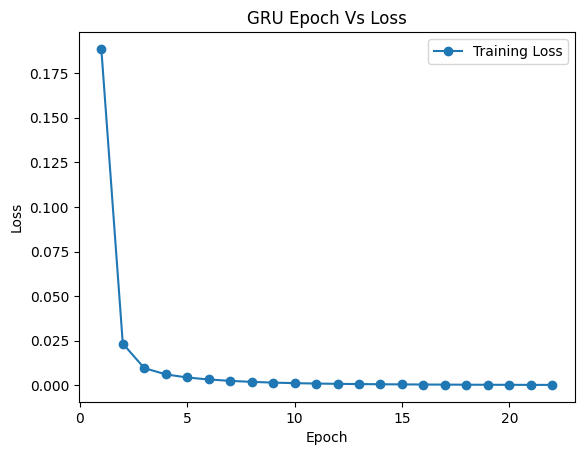

In [66]:
# Create the GRU model
torch.manual_seed(1000)
gru_model = CustomGRU(input_size = size_of_input, hidden_size = hidden_size, output_size = size_of_output)
print('Printing GRU:', gru_model)

# Train GRU model
loss_function = nn.MSELoss()
optimizer = torch.optim.NAdam(gru_model.parameters(), lr=lr)
epoch_loss_dict_GRU = fit_GRU(optimizer, loss_function, gru_model, X_train, Y_train, epochs = epochs)
plot_loss(epoch_loss_dict_GRU, 'GRU Epoch Vs Loss')

**Calculating Baseline:**

In [67]:
def calculate_loss_for_baseline(epoch_loss_dict_baseline, epochs):
  Y_true = torch.tensor(1).to(device)
  for ep in range(1, epochs + 1, 1):
    temp_list = [nn.MSELoss()(Y_true, Y_pred.to(device)).item() for _, Y_pred in zip(X_train, Y_train)]
    epoch_loss_dict_baseline[ep] = torch.tensor(temp_list).mean()
  return epoch_loss_dict_baseline

In [68]:
# Calculating loss for baseline model
epoch_loss_dict_baseline = OrderedDict()
epoch_loss_dict_baseline = calculate_loss_for_baseline(epoch_loss_dict_baseline, epochs)

**Comparing all models:**

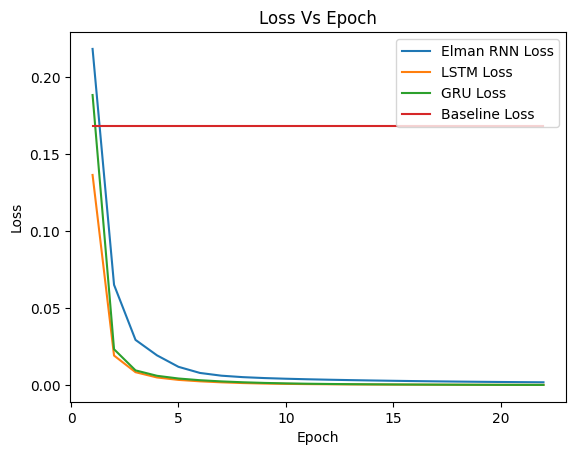

In [69]:
loss_dicts = [epoch_loss_dict_rnn, epoch_loss_dict_LSTM, epoch_loss_dict_GRU, epoch_loss_dict_baseline]
labels = ['Elman RNN Loss', 'LSTM Loss', 'GRU Loss', 'Baseline Loss']

plt.figure()
for loss_dict, label in zip(loss_dicts, labels):
    plt.plot(loss_dict.keys(), loss_dict.values(), label=label)

plt.title('Loss Vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

**We can observe that,  
Loss of Elman RNN > Loss of LSTM > Loss of GRU  
Hence, Performance of Elman RNN < Performance of LSTM < Performance of GRU**

---